In [74]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [2]:
data = pd.read_csv('study_72_processed.csv', index_col=0, dtype={'Disease': str})

In [3]:
feature_data = data.T[['npeaks','pcgroup','drt']].T.drop('Disease', axis=1)
data_d = data.T.drop(labels=['npeaks','pcgroup', 'drt'], axis=1).T

In [4]:
(X,y) = (data_d.drop('Disease', axis=1), data_d['Disease'])
dummies=pd.get_dummies(y)
y = dummies.iloc[:,0].values

In [5]:
feature_scaler = StandardScaler()
feature_data_scaled = feature_scaler.fit_transform(feature_data.T[['npeaks','drt']])
feature_data.T[['npeaks', 'drt']] = feature_data_scaled 

In [6]:
from sklearn.cross_validation import train_test_split

/Users/alimladha/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

In [8]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_data, npeaks=0, drt=0, group=False, log_scale=False):
        self.npeaks = npeaks
        self.drt = drt
        self.group = group
        self.feature_data = feature_data
        self.log_scale = log_scale
        
    def fit(self, x, y = None):
        return self
    
    def transform(self, data):
        if self.log_scale:
            data = data.fillna(1).apply(np.log10)
        else:
            data = data.fillna(0)
        data = data.astype(float)
        data = pd.concat([data,feature_data], axis=0)
        data = data.T
        index_to_drop=[]
        for index,row in data.iterrows():
            npeaks_data = row['npeaks']
            drt_data = row['drt']
            if npeaks_data<self.npeaks or drt_data<self.drt:
                index_to_drop.append(index)
        data = data.drop(index_to_drop).drop(['npeaks','drt'], axis=1)
        if self.group:
            data = data.astype(float).groupby('pcgroup').mean().T.values
        else:
            data = data.astype(float).drop('pcgroup', axis=1).T.values
        return data

In [79]:
feature_selector = FeatureSelector(feature_data=feature_data, npeaks = 0.5, drt = 0.5, group=True, log_scale=True)
scaler = StandardScaler()
pca = PCA(n_components=2)
clf = SVC()
estimators = [('select_features',feature_selector),('scale',scaler), ('reduce_dim',pca), ('clf',clf)]
pipe = Pipeline(estimators)

In [87]:
npeaks = [0, 0.5]
drts = [0, 0.5]
interizer = np.vectorize(int)
Cs = np.logspace(-4,4,3)
param_grid = dict(select_features__npeaks = npeaks,
                  select_features__drt = drts,
                  select_features__group = [True, False], 
                  reduce_dim = [None,PCA(50), PCA(None)],
                  clf__kernel = ['rbf','linear', 'poly'],
                  clf__C = Cs
                 )

In [88]:
estimator = GridSearchCV(pipe,param_grid=param_grid, verbose=10, n_jobs=-1)
estimator.fit(X_train,y_train)

Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV] clf__C=0.0001, clf__kernel=rbf, reduce_dim=None, select_features__drt=0, select_features__group=True, select_features__npeaks=0 
[CV] clf__C=0.0001, clf__kernel=rbf, reduce_dim=None, select_features__drt=0, select_features__group=True, select_features__npeaks=0 
[CV] clf__C=0.0001, clf__kernel=rbf, reduce_dim=None, select_features__drt=0, select_features__group=True, select_features__npeaks=0 
[CV] clf__C=0.0001, clf__kernel=rbf, reduce_dim=None, select_features__drt=0, select_features__group=True, select_features__npeaks=0.5 
[CV]  clf__C=0.0001, clf__kernel=rbf, reduce_dim=None, select_features__drt=0, select_features__group=True, select_features__npeaks=0, score=0.6911764705882353, total=   9.3s
[CV]  clf__C=0.0001, clf__kernel=rbf, reduce_dim=None, select_features__drt=0, select_features__group=True, select_features__npeaks=0, score=0.6911764705882353, total=   9.1s
[CV] clf__C=0.0001, clf__kernel=rbf, reduce_dim=N

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   28.1s


[CV]  clf__C=0.0001, clf__kernel=rbf, reduce_dim=None, select_features__drt=0, select_features__group=True, select_features__npeaks=0.5, score=0.7014925373134329, total=   8.4s
[CV] clf__C=0.0001, clf__kernel=rbf, reduce_dim=None, select_features__drt=0, select_features__group=False, select_features__npeaks=0 
[CV]  clf__C=0.0001, clf__kernel=rbf, reduce_dim=None, select_features__drt=0, select_features__group=False, select_features__npeaks=0, score=0.6911764705882353, total=   8.4s
[CV] clf__C=0.0001, clf__kernel=rbf, reduce_dim=None, select_features__drt=0, select_features__group=False, select_features__npeaks=0.5 
[CV]  clf__C=0.0001, clf__kernel=rbf, reduce_dim=None, select_features__drt=0, select_features__group=False, select_features__npeaks=0, score=0.6911764705882353, total=   8.2s
[CV] clf__C=0.0001, clf__kernel=rbf, reduce_dim=None, select_features__drt=0, select_features__group=False, select_features__npeaks=0.5 
[CV] clf__C=0.0001, clf__kernel=rbf, reduce_dim=None, select_f

[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   43.1s


[CV] clf__C=0.0001, clf__kernel=rbf, reduce_dim=None, select_features__drt=0.5, select_features__group=True, select_features__npeaks=0 
[CV]  clf__C=0.0001, clf__kernel=rbf, reduce_dim=None, select_features__drt=0, select_features__group=False, select_features__npeaks=0.5, score=0.6911764705882353, total=   8.4s
[CV] clf__C=0.0001, clf__kernel=rbf, reduce_dim=None, select_features__drt=0.5, select_features__group=True, select_features__npeaks=0 
[CV]  clf__C=0.0001, clf__kernel=rbf, reduce_dim=None, select_features__drt=0, select_features__group=False, select_features__npeaks=0.5, score=0.7014925373134329, total=   8.4s
[CV] clf__C=0.0001, clf__kernel=rbf, reduce_dim=None, select_features__drt=0.5, select_features__group=True, select_features__npeaks=0.5 
[CV]  clf__C=0.0001, clf__kernel=rbf, reduce_dim=None, select_features__drt=0.5, select_features__group=True, select_features__npeaks=0, score=0.6911764705882353, total=   8.5s
[CV]  clf__C=0.0001, clf__kernel=rbf, reduce_dim=None, se

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.2min


[CV] clf__C=0.0001, clf__kernel=rbf, reduce_dim=None, select_features__drt=0.5, select_features__group=False, select_features__npeaks=0 
[CV]  clf__C=0.0001, clf__kernel=rbf, reduce_dim=None, select_features__drt=0.5, select_features__group=True, select_features__npeaks=0.5, score=0.7014925373134329, total=   8.1s
[CV] clf__C=0.0001, clf__kernel=rbf, reduce_dim=None, select_features__drt=0.5, select_features__group=False, select_features__npeaks=0.5 
[CV]  clf__C=0.0001, clf__kernel=rbf, reduce_dim=None, select_features__drt=0.5, select_features__group=False, select_features__npeaks=0, score=0.6911764705882353, total=   8.1s
[CV] clf__C=0.0001, clf__kernel=rbf, reduce_dim=None, select_features__drt=0.5, select_features__group=False, select_features__npeaks=0.5 
[CV]  clf__C=0.0001, clf__kernel=rbf, reduce_dim=None, select_features__drt=0.5, select_features__group=False, select_features__npeaks=0, score=0.6911764705882353, total=   8.1s
[CV] clf__C=0.0001, clf__kernel=rbf, reduce_dim=No

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.4min


[CV] clf__C=0.0001, clf__kernel=rbf, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=True, select_features__npeaks=0.5 
[CV]  clf__C=0.0001, clf__kernel=rbf, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=True, select_features__npeaks=0, score=0.6911764705882353, total=   8.5s
[CV] clf__C=0.0001, clf__kernel=rbf, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=True, select_features__npeaks=0.5 
[CV]  clf__C=0.0001, clf__kernel=rbf, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.1min


[CV] clf__C=0.0001, clf__kernel=rbf, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=True, select_features__npeaks=0 
[CV]  clf__C=0.0001, clf__kernel=rbf, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=False, select_features__npeaks=0.5, score=0.6911764705882353, total=   8.4s
[CV] clf__C=0.0001, clf__kernel=rbf, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=True, select_features__npeaks=0 
[CV]  clf__C=0.0001, clf__kernel=rbf, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__gr

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.5min


[CV] clf__C=0.0001, clf__kernel=rbf, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=False, select_features__npeaks=0.5 
[CV]  clf__C=0.0001, clf__kernel=rbf, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=False, select_features__npeaks=0, score=0.6911764705882353, total=   8.8s
[CV] clf__C=0.0001, clf__kernel=rbf, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=False, select_features__npeaks=0.5 
[CV]  clf__C=0.0001, clf__kernel=rbf, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_feat

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  3.2min


[CV] clf__C=0.0001, clf__kernel=rbf, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=False, select_features__npeaks=0 
[CV]  clf__C=0.0001, clf__kernel=rbf, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=True, select_features__npeaks=0.5, score=0.7014925373134329, total=   8.4s
[CV] clf__C=0.0001, clf__kernel=rbf, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=False, select_features__npeaks=0.5 
[CV]  clf__C=0.0001, clf__kernel=rbf, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_featu

[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  3.7min


[CV] clf__C=0.0001, clf__kernel=rbf, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=False, select_features__npeaks=0 
[CV]  clf__C=0.0001, clf__kernel=rbf, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=True, select_features__npeaks=0.5, score=0.6911764705882353, total=   8.7s
[CV] clf__C=0.0001, clf__kernel=rbf, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=False, select_features__npeaks=0 
[CV]  clf__C=0.0001, clf__kernel=rbf, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select

[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  4.5min


[CV] clf__C=0.0001, clf__kernel=linear, reduce_dim=None, select_features__drt=0, select_features__group=False, select_features__npeaks=0 
[CV]  clf__C=0.0001, clf__kernel=linear, reduce_dim=None, select_features__drt=0, select_features__group=True, select_features__npeaks=0.5, score=0.7014925373134329, total=   8.3s
[CV] clf__C=0.0001, clf__kernel=linear, reduce_dim=None, select_features__drt=0, select_features__group=False, select_features__npeaks=0.5 
[CV]  clf__C=0.0001, clf__kernel=linear, reduce_dim=None, select_features__drt=0, select_features__group=False, select_features__npeaks=0, score=0.6911764705882353, total=   8.3s
[CV] clf__C=0.0001, clf__kernel=linear, reduce_dim=None, select_features__drt=0, select_features__group=False, select_features__npeaks=0.5 
[CV]  clf__C=0.0001, clf__kernel=linear, reduce_dim=None, select_features__drt=0, select_features__group=False, select_features__npeaks=0, score=0.6911764705882353, total=   8.0s
[CV] clf__C=0.0001, clf__kernel=linear, redu

[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  5.2min


[CV] clf__C=0.0001, clf__kernel=linear, reduce_dim=None, select_features__drt=0.5, select_features__group=False, select_features__npeaks=0.5 
[CV]  clf__C=0.0001, clf__kernel=linear, reduce_dim=None, select_features__drt=0.5, select_features__group=False, select_features__npeaks=0, score=0.6911764705882353, total=   8.0s
[CV] clf__C=0.0001, clf__kernel=linear, reduce_dim=None, select_features__drt=0.5, select_features__group=False, select_features__npeaks=0.5 
[CV]  clf__C=0.0001, clf__kernel=linear, reduce_dim=None, select_features__drt=0.5, select_features__group=False, select_features__npeaks=0, score=0.6911764705882353, total=   8.1s
[CV] clf__C=0.0001, clf__kernel=linear, reduce_dim=None, select_features__drt=0.5, select_features__group=False, select_features__npeaks=0.5 
[CV]  clf__C=0.0001, clf__kernel=linear, reduce_dim=None, select_features__drt=0.5, select_features__group=False, select_features__npeaks=0, score=0.7313432835820896, total=   8.8s
[CV] clf__C=0.0001, clf__kernel

[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  6.1min


[CV] clf__C=0.0001, clf__kernel=linear, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=True, select_features__npeaks=0 
[CV]  clf__C=0.0001, clf__kernel=linear, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=False, select_features__npeaks=0.5, score=0.6911764705882353, total=   8.3s
[CV] clf__C=0.0001, clf__kernel=linear, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=True, select_features__npeaks=0 
[CV]  clf__C=0.0001, clf__kernel=linear, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_

  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=False, select_features__npeaks=0.5, score=0.7014925373134329, total=   8.2s


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  6.8min


[CV] clf__C=0.0001, clf__kernel=linear, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=True, select_features__npeaks=0.5 
[CV]  clf__C=0.0001, clf__kernel=linear, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=True, select_features__npeaks=0, score=0.6911764705882353, total=   8.8s
[CV] clf__C=0.0001, clf__kernel=linear, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=True, select_features__npeaks=0.5 
[CV]  clf__C=0.0001, clf__kernel=linear, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, se

  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=True, select_features__npeaks=0, score=0.7014925373134329, total=   8.3s
[CV]  clf__C=0.0001, clf__kernel=linear, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=True, select_features__npeaks=0.5, score=0.6911764705882353, total=   8.1s

[CV] clf__C=0.0001, clf__kernel=linear, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=False, select_features__npeaks=0 [CV] clf__C=0.0001, clf__kernel=linear, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=False, select_features__npeaks=0 
[CV]  clf__C=0.0001, clf__

[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  7.9min


[CV] clf__C=0.0001, clf__kernel=linear, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=False, select_features__npeaks=0 
[CV]  clf__C=0.0001, clf__kernel=linear, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=True, select_features__npeaks=0.5, score=0.7014925373134329, total=   8.4s
[CV] clf__C=0.0001, clf__kernel=linear, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=False, select_features__npeaks=0.5 
[CV]  clf__C=0.0001, clf__kernel=linear, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__d

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  8.9min


[CV] clf__C=0.0001, clf__kernel=poly, reduce_dim=None, select_features__drt=0.5, select_features__group=True, select_features__npeaks=0 
[CV]  clf__C=0.0001, clf__kernel=poly, reduce_dim=None, select_features__drt=0, select_features__group=False, select_features__npeaks=0.5, score=0.6911764705882353, total=   8.2s
[CV] clf__C=0.0001, clf__kernel=poly, reduce_dim=None, select_features__drt=0.5, select_features__group=True, select_features__npeaks=0 
[CV]  clf__C=0.0001, clf__kernel=poly, reduce_dim=None, select_features__drt=0, select_features__group=False, select_features__npeaks=0.5, score=0.7014925373134329, total=   8.3s
[CV] clf__C=0.0001, clf__kernel=poly, reduce_dim=None, select_features__drt=0.5, select_features__group=True, select_features__npeaks=0.5 
[CV]  clf__C=0.0001, clf__kernel=poly, reduce_dim=None, select_features__drt=0.5, select_features__group=True, select_features__npeaks=0, score=0.6911764705882353, total=   8.4s
[CV] clf__C=0.0001, clf__kernel=poly, reduce_dim=No

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  9.9min


[CV] clf__C=0.0001, clf__kernel=poly, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=False, select_features__npeaks=0 
[CV]  clf__C=0.0001, clf__kernel=poly, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=True, select_features__npeaks=0.5, score=0.7014925373134329, total=   8.3s
[CV]  clf__C=0.0001, clf__kernel=poly, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=False, select_features__npeaks=0, score=0.8529411764705882, total=   8.2s

[CV] clf__C=0.0001, clf__kernel=poly, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), s

  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=False, select_features__npeaks=0.5 
[CV]  clf__C=0.0001, clf__kernel=poly, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=False, select_features__npeaks=0, score=0.7164179104477612, total=   8.9s
[CV] clf__C=0.0001, clf__kernel=poly, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=True, select_features__npeaks=0 
[CV]  clf__C=0.0001, clf__kernel=poly, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=False, select_features__npeaks=0.5, score=0.7352941176470589, total=   8.5s
[CV] clf__C=0.0001, clf__kernel=po

[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 10.9min


[CV] clf__C=0.0001, clf__kernel=poly, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=True, select_features__npeaks=0.5 
[CV]  clf__C=0.0001, clf__kernel=poly, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=True, select_features__npeaks=0, score=0.6911764705882353, total=   8.4s
[CV] clf__C=0.0001, clf__kernel=poly, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=True, select_features__npeaks=0.5 
[CV]  clf__C=0.0001, clf__kernel=poly, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_fea

  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=False, select_features__npeaks=0 
[CV]  clf__C=0.0001, clf__kernel=poly, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=True, select_features__npeaks=0.5, score=0.6911764705882353, total=   8.6s
[CV] clf__C=0.0001, clf__kernel=poly, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=False, select_features__npeaks=0 
[CV]  clf__C=0.0001, clf__kernel=poly, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=True, select_features__npeaks=0.5, score=0.6911764705882353, total=   8.4s
[CV] clf__C=0.0001, clf__kern

[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed: 12.1min


[CV] clf__C=1.0, clf__kernel=rbf, reduce_dim=None, select_features__drt=0, select_features__group=True, select_features__npeaks=0 
[CV]  clf__C=0.0001, clf__kernel=poly, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=False, select_features__npeaks=0.5, score=0.6911764705882353, total=   8.4s
[CV] clf__C=1.0, clf__kernel=rbf, reduce_dim=None, select_features__drt=0, select_features__group=True, select_features__npeaks=0 
[CV]  clf__C=0.0001, clf__kernel=poly, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=False, select_features__npeaks=0.5, score=0.6911764705882353, total=   8.7s
[CV] clf__C=1.0, clf__kernel=rbf, reduce_dim=None, select_features__drt=0, select_features__group=True, select_features__npeaks=0 
[CV]  clf__C=0.

[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed: 13.3min


[CV] clf__C=1.0, clf__kernel=rbf, reduce_dim=None, select_features__drt=0.5, select_features__group=False, select_features__npeaks=0.5 
[CV]  clf__C=1.0, clf__kernel=rbf, reduce_dim=None, select_features__drt=0.5, select_features__group=False, select_features__npeaks=0, score=0.8235294117647058, total=   8.1s
[CV] clf__C=1.0, clf__kernel=rbf, reduce_dim=None, select_features__drt=0.5, select_features__group=False, select_features__npeaks=0.5 
[CV]  clf__C=1.0, clf__kernel=rbf, reduce_dim=None, select_features__drt=0.5, select_features__group=False, select_features__npeaks=0, score=0.8529411764705882, total=   8.1s
[CV] clf__C=1.0, clf__kernel=rbf, reduce_dim=None, select_features__drt=0.5, select_features__group=False, select_features__npeaks=0.5 
[CV]  clf__C=1.0, clf__kernel=rbf, reduce_dim=None, select_features__drt=0.5, select_features__group=False, select_features__npeaks=0, score=0.6865671641791045, total=   8.3s
[CV] clf__C=1.0, clf__kernel=rbf, reduce_dim=PCA(copy=True, iterate

  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=True, select_features__npeaks=0 
[CV]  clf__C=1.0, clf__kernel=rbf, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=False, select_features__npeaks=0.5, score=0.7014925373134329, total=   8.3s
[CV] clf__C=1.0, clf__kernel=rbf, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=True, select_features__npeaks=0.5 
[CV]  clf__C=1.0, clf__kernel=rbf, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=True, select_features__npeaks=0, score=0.7058823529411765, total=   8.7s
[CV] clf__C=1.0, clf__kernel=rbf, reduce_dim=PCA(c

[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed: 14.6min


[CV] clf__C=1.0, clf__kernel=rbf, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=False, select_features__npeaks=0 
[CV]  clf__C=1.0, clf__kernel=rbf, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=True, select_features__npeaks=0.5, score=0.6567164179104478, total=   8.3s
[CV] clf__C=1.0, clf__kernel=rbf, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=False, select_features__npeaks=0.5 
[CV]  clf__C=1.0, clf__kernel=rbf, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=F

  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=False, select_features__npeaks=0.5 
[CV]  clf__C=1.0, clf__kernel=rbf, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=False, select_features__npeaks=0, score=0.7014925373134329, total=   8.6s
[CV] clf__C=1.0, clf__kernel=rbf, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=True, select_features__npeaks=0 
[CV]  clf__C=1.0, clf__kernel=rbf, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=False, select_features__npeaks=0.5, score=0.7058823529411765, total=   8.5s
[CV] clf__C=1.0, clf__kernel=rbf, reduce_dim=P

[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 15.8min


[CV] clf__C=1.0, clf__kernel=rbf, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=False, select_features__npeaks=0 
[CV]  clf__C=1.0, clf__kernel=rbf, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=True, select_features__npeaks=0.5, score=0.8088235294117647, total=   8.7s
[CV] clf__C=1.0, clf__kernel=rbf, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=False, select_features__npeaks=0 
[CV]  clf__C=1.0, clf__kernel=rbf, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__g

[CV]  clf__C=1.0, clf__kernel=linear, reduce_dim=None, select_features__drt=0.5, select_features__group=True, select_features__npeaks=0, score=0.8059701492537313, total=   8.1s
[CV] clf__C=1.0, clf__kernel=linear, reduce_dim=None, select_features__drt=0.5, select_features__group=True, select_features__npeaks=0.5 
[CV]  clf__C=1.0, clf__kernel=linear, reduce_dim=None, select_features__drt=0.5, select_features__group=True, select_features__npeaks=0.5, score=0.8088235294117647, total=   7.9s
[CV] clf__C=1.0, clf__kernel=linear, reduce_dim=None, select_features__drt=0.5, select_features__group=False, select_features__npeaks=0 
[CV] clf__C=1.0, clf__kernel=linear, reduce_dim=None, select_features__drt=0.5, select_features__group=False, select_features__npeaks=0 
[CV]  clf__C=1.0, clf__kernel=linear, reduce_dim=None, select_features__drt=0.5, select_features__group=True, select_features__npeaks=0.5, score=0.8088235294117647, total=   8.2s


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed: 17.3min


[CV] clf__C=1.0, clf__kernel=linear, reduce_dim=None, select_features__drt=0.5, select_features__group=False, select_features__npeaks=0 
[CV]  clf__C=1.0, clf__kernel=linear, reduce_dim=None, select_features__drt=0.5, select_features__group=True, select_features__npeaks=0.5, score=0.7910447761194029, total=   8.3s
[CV]  clf__C=1.0, clf__kernel=linear, reduce_dim=None, select_features__drt=0.5, select_features__group=False, select_features__npeaks=0, score=0.8088235294117647, total=   8.0s
[CV] clf__C=1.0, clf__kernel=linear, reduce_dim=None, select_features__drt=0.5, select_features__group=False, select_features__npeaks=0.5 
[CV]  clf__C=1.0, clf__kernel=linear, reduce_dim=None, select_features__drt=0.5, select_features__group=False, select_features__npeaks=0, score=0.8529411764705882, total=   7.9s
[CV] clf__C=1.0, clf__kernel=linear, reduce_dim=None, select_features__drt=0.5, select_features__group=False, select_features__npeaks=0.5 
[CV] clf__C=1.0, clf__kernel=linear, reduce_dim=No

  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=False, select_features__npeaks=0.5, score=0.7205882352941176, total=   8.0s
[CV] clf__C=1.0, clf__kernel=linear, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=True, select_features__npeaks=0 
[CV]  clf__C=1.0, clf__kernel=linear, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=False, select_features__npeaks=0.5, score=0.7761194029850746, total=   7.9s

[CV] clf__C=1.0, clf__kernel=linear, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=True, select_features__npeaks=0 [CV] clf__C=1.0, clf__kernel=linear, reduce

[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed: 18.6min


[CV]  clf__C=1.0, clf__kernel=linear, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=False, select_features__npeaks=0, score=0.7794117647058824, total=   7.9s
[CV] clf__C=1.0, clf__kernel=linear, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=False, select_features__npeaks=0.5 
[CV] clf__C=1.0, clf__kernel=linear, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=False, select_features__npeaks=0.5 
[CV]  clf__C=1.0, clf__kernel=linear, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_feat

  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=True, select_features__npeaks=0 
[CV]  clf__C=1.0, clf__kernel=linear, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=False, select_features__npeaks=0.5, score=0.8235294117647058, total=   7.8s
[CV]  clf__C=1.0, clf__kernel=linear, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=False, select_features__npeaks=0.5, score=0.8235294117647058, total=   7.6s

[CV] clf__C=1.0, clf__kernel=linear, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=True, select_features__npeaks=0 [CV] clf__C=1.0, clf__kernel=linear,

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 20.1min


[CV] clf__C=1.0, clf__kernel=poly, reduce_dim=None, select_features__drt=0, select_features__group=True, select_features__npeaks=0 
[CV]  clf__C=1.0, clf__kernel=linear, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=False, select_features__npeaks=0.5, score=0.8382352941176471, total=   7.8s
[CV]  clf__C=1.0, clf__kernel=linear, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=False, select_features__npeaks=0.5, score=0.8088235294117647, total=   7.6s[CV] clf__C=1.0, clf__kernel=poly, reduce_dim=None, select_features__drt=0, select_features__group=True, select_features__npeaks=0 

[CV]  clf__C=1.0, clf__kernel=linear, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', 

[CV]  clf__C=1.0, clf__kernel=poly, reduce_dim=None, select_features__drt=0.5, select_features__group=False, select_features__npeaks=0.5, score=0.7794117647058824, total=   7.6s

[CV] clf__C=1.0, clf__kernel=poly, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=True, select_features__npeaks=0 [CV] clf__C=1.0, clf__kernel=poly, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=True, select_features__npeaks=0 
[CV]  clf__C=1.0, clf__kernel=poly, reduce_dim=None, select_features__drt=0.5, select_features__group=False, select_features__npeaks=0.5, score=0.746268656716418, total=   7.7s


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed: 21.4min


[CV] clf__C=1.0, clf__kernel=poly, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=True, select_features__npeaks=0.5 
[CV]  clf__C=1.0, clf__kernel=poly, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=True, select_features__npeaks=0, score=0.8088235294117647, total=   8.0s
[CV] clf__C=1.0, clf__kernel=poly, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=True, select_features__npeaks=0.5 
[CV]  clf__C=1.0, clf__kernel=poly, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=True, s

  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=False, select_features__npeaks=0 
[CV]  clf__C=1.0, clf__kernel=poly, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=True, select_features__npeaks=0.5, score=0.8235294117647058, total=   7.7s
[CV] clf__C=1.0, clf__kernel=poly, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=False, select_features__npeaks=0 
[CV]  clf__C=1.0, clf__kernel=poly, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=True, select_features__npeaks=0.5, score=0.75, total=   7.9s
[CV] clf__C=1.0, clf__kernel=poly, reduce_dim=PCA(copy=Tru

[Parallel(n_jobs=-1)]: Done 413 tasks      | elapsed: 23.0min


[CV] clf__C=1.0, clf__kernel=poly, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=False, select_features__npeaks=0 
[CV]  clf__C=1.0, clf__kernel=poly, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=True, select_features__npeaks=0.5, score=0.7164179104477612, total=   7.7s
[CV] clf__C=1.0, clf__kernel=poly, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=False, select_features__npeaks=0.5 
[CV]  clf__C=1.0, clf__kernel=poly, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__gro

  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=False, select_features__npeaks=0.5 
[CV]  clf__C=1.0, clf__kernel=poly, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=False, select_features__npeaks=0, score=0.7164179104477612, total=   7.9s
[CV] clf__C=10000.0, clf__kernel=rbf, reduce_dim=None, select_features__drt=0, select_features__group=True, select_features__npeaks=0 
[CV]  clf__C=1.0, clf__kernel=poly, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=False, select_features__npeaks=0.5, score=0.8529411764705882, total=   7.8s
[CV] clf__C=10000.0, clf__kernel=rbf, reduce_dim=None, select_features__drt=0, select_features__group=True, select_features__npeaks=0 
[CV]  clf__C=1.0

[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 24.5min


[CV] clf__C=10000.0, clf__kernel=rbf, reduce_dim=None, select_features__drt=0.5, select_features__group=True, select_features__npeaks=0 
[CV]  clf__C=10000.0, clf__kernel=rbf, reduce_dim=None, select_features__drt=0, select_features__group=False, select_features__npeaks=0.5, score=0.8676470588235294, total=   7.8s
[CV]  clf__C=10000.0, clf__kernel=rbf, reduce_dim=None, select_features__drt=0, select_features__group=False, select_features__npeaks=0.5, score=0.7910447761194029, total=   7.8s
[CV] clf__C=10000.0, clf__kernel=rbf, reduce_dim=None, select_features__drt=0.5, select_features__group=True, select_features__npeaks=0 
[CV] clf__C=10000.0, clf__kernel=rbf, reduce_dim=None, select_features__drt=0.5, select_features__group=True, select_features__npeaks=0.5 
[CV]  clf__C=10000.0, clf__kernel=rbf, reduce_dim=None, select_features__drt=0.5, select_features__group=True, select_features__npeaks=0, score=0.8676470588235294, total=   8.0s
[CV] clf__C=10000.0, clf__kernel=rbf, reduce_dim=No

  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=False, select_features__npeaks=0.5 
[CV]  clf__C=10000.0, clf__kernel=rbf, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=False, select_features__npeaks=0, score=0.6911764705882353, total=   7.8s
[CV]  clf__C=10000.0, clf__kernel=rbf, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=False, select_features__npeaks=0, score=0.6911764705882353, total=   7.8s
[CV] clf__C=10000.0, clf__kernel=rbf, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=False, select_features__npeaks=0.5 
[CV] clf__C=10000.0, clf__kernel=rbf, red

[Parallel(n_jobs=-1)]: Done 473 tasks      | elapsed: 26.1min


[CV] clf__C=10000.0, clf__kernel=rbf, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=False, select_features__npeaks=0 
[CV]  clf__C=10000.0, clf__kernel=rbf, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=True, select_features__npeaks=0.5, score=0.6865671641791045, total=   8.0s
[CV] clf__C=10000.0, clf__kernel=rbf, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=False, select_features__npeaks=0.5 
[CV]  clf__C=10000.0, clf__kernel=rbf, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_f

  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=False, select_features__npeaks=0.5 
[CV]  clf__C=10000.0, clf__kernel=rbf, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=False, select_features__npeaks=0, score=0.6716417910447762, total=   8.1s
[CV] clf__C=10000.0, clf__kernel=rbf, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=True, select_features__npeaks=0 
[CV]  clf__C=10000.0, clf__kernel=rbf, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=False, select_features__npeaks=0.5, score=0.75, total=   8.1s
[CV] clf__C=10000.0, clf__kernel=rbf, reduce_dim

  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=False, select_features__npeaks=0.5, score=0.7313432835820896, total=   8.2s


[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed: 27.7min


[CV] clf__C=10000.0, clf__kernel=linear, reduce_dim=None, select_features__drt=0, select_features__group=True, select_features__npeaks=0.5 
[CV]  clf__C=10000.0, clf__kernel=linear, reduce_dim=None, select_features__drt=0, select_features__group=True, select_features__npeaks=0, score=0.8382352941176471, total=   8.0s
[CV] clf__C=10000.0, clf__kernel=linear, reduce_dim=None, select_features__drt=0, select_features__group=True, select_features__npeaks=0.5 
[CV]  clf__C=10000.0, clf__kernel=linear, reduce_dim=None, select_features__drt=0, select_features__group=True, select_features__npeaks=0, score=0.8235294117647058, total=   7.8s
[CV] clf__C=10000.0, clf__kernel=linear, reduce_dim=None, select_features__drt=0, select_features__group=True, select_features__npeaks=0.5 
[CV]  clf__C=10000.0, clf__kernel=linear, reduce_dim=None, select_features__drt=0, select_features__group=True, select_features__npeaks=0, score=0.8208955223880597, total=   7.8s
[CV] clf__C=10000.0, clf__kernel=linear, re

  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=True, select_features__npeaks=0.5 
[CV]  clf__C=10000.0, clf__kernel=linear, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=True, select_features__npeaks=0, score=0.7647058823529411, total=   8.1s
[CV] clf__C=10000.0, clf__kernel=linear, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=True, select_features__npeaks=0.5 
[CV]  clf__C=10000.0, clf__kernel=linear, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=True, select_features__npeaks=0, score=0.7352941176470589, total=   7.9s
[CV] clf__C=10000.0, clf__kernel=lin

[Parallel(n_jobs=-1)]: Done 537 tasks      | elapsed: 29.5min


[CV] clf__C=10000.0, clf__kernel=linear, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=True, select_features__npeaks=0 
[CV]  clf__C=10000.0, clf__kernel=linear, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=False, select_features__npeaks=0.5, score=0.7647058823529411, total=   7.9s
[CV]  clf__C=10000.0, clf__kernel=linear, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=False, select_features__npeaks=0.5, score=0.7941176470588235, total=   7.9s[CV] clf__C=10000.0, clf__kernel=linear, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, wh

  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=False, select_features__npeaks=0.5, score=0.7910447761194029, total=   7.8s
[CV] clf__C=10000.0, clf__kernel=linear, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=True, select_features__npeaks=0.5 
[CV]  clf__C=10000.0, clf__kernel=linear, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=True, select_features__npeaks=0, score=0.8382352941176471, total=   8.2s
[CV] clf__C=10000.0, clf__kernel=linear, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=True, select_features__npeaks=0.5 
[CV]  clf__C=10000.0, clf_

  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=True, select_features__npeaks=0, score=0.8059701492537313, total=   8.3s
[CV] clf__C=10000.0, clf__kernel=linear, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=False, select_features__npeaks=0 
[CV]  clf__C=10000.0, clf__kernel=linear, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=True, select_features__npeaks=0.5, score=0.8088235294117647, total=   8.2s
[CV] clf__C=10000.0, clf__kernel=linear, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=False, select_features__npeaks=0 
[CV]  clf__C=10000.0, c

[Parallel(n_jobs=-1)]: Done 570 tasks      | elapsed: 31.3min


[CV] clf__C=10000.0, clf__kernel=linear, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=False, select_features__npeaks=0.5 
[CV]  clf__C=10000.0, clf__kernel=linear, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=False, select_features__npeaks=0, score=0.8088235294117647, total=   8.1s
[CV] clf__C=10000.0, clf__kernel=linear, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=False, select_features__npeaks=0.5 
[CV]  clf__C=10000.0, clf__kernel=linear, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_featur

[CV] clf__C=10000.0, clf__kernel=poly, reduce_dim=None, select_features__drt=0.5, select_features__group=False, select_features__npeaks=0 
[CV]  clf__C=10000.0, clf__kernel=poly, reduce_dim=None, select_features__drt=0.5, select_features__group=True, select_features__npeaks=0.5, score=0.7611940298507462, total=   7.7s
[CV] clf__C=10000.0, clf__kernel=poly, reduce_dim=None, select_features__drt=0.5, select_features__group=False, select_features__npeaks=0.5 
[CV]  clf__C=10000.0, clf__kernel=poly, reduce_dim=None, select_features__drt=0.5, select_features__group=False, select_features__npeaks=0, score=0.8676470588235294, total=   8.1s
[CV]  clf__C=10000.0, clf__kernel=poly, reduce_dim=None, select_features__drt=0.5, select_features__group=False, select_features__npeaks=0, score=0.8382352941176471, total=   7.9s
[CV] clf__C=10000.0, clf__kernel=poly, reduce_dim=None, select_features__drt=0.5, select_features__group=False, select_features__npeaks=0.5 
[CV] clf__C=10000.0, clf__kernel=poly,

[Parallel(n_jobs=-1)]: Done 605 tasks      | elapsed: 33.1min


[CV] clf__C=10000.0, clf__kernel=poly, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=False, select_features__npeaks=0 
[CV]  clf__C=10000.0, clf__kernel=poly, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=True, select_features__npeaks=0.5, score=0.7313432835820896, total=   7.7s
[CV] clf__C=10000.0, clf__kernel=poly, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=False, select_features__npeaks=0.5 
[CV]  clf__C=10000.0, clf__kernel=poly, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_featu

  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=False, select_features__npeaks=0.5 
[CV]  clf__C=10000.0, clf__kernel=poly, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=False, select_features__npeaks=0, score=0.7164179104477612, total=   7.8s
[CV] clf__C=10000.0, clf__kernel=poly, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=True, select_features__npeaks=0 
[CV]  clf__C=10000.0, clf__kernel=poly, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=False, select_features__npeaks=0.5, score=0.8235294117647058, total=   7.8s
[CV] clf__C=10000.0, clf__kerne

  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=False, select_features__npeaks=0.5, score=0.7313432835820896, total=   8.0s
[CV] clf__C=10000.0, clf__kernel=poly, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=True, select_features__npeaks=0 
[CV] clf__C=10000.0, clf__kernel=poly, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=True, select_features__npeaks=0.5 
[CV]  clf__C=10000.0, clf__kernel=poly, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=True, select_features__npeaks=0, score=0.8529411764705882, total=   7.8s
[CV] clf__C=10000.0, clf__kern

[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 34.9min


[CV] clf__C=10000.0, clf__kernel=poly, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=False, select_features__npeaks=0 
[CV]  clf__C=10000.0, clf__kernel=poly, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=True, select_features__npeaks=0.5, score=0.7941176470588235, total=   7.7s
[CV] clf__C=10000.0, clf__kernel=poly, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=False, select_features__npeaks=0 
[CV]  clf__C=10000.0, clf__kernel=poly, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5

[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed: 35.3min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('select_features', FeatureSelector(drt=0.5,
        feature_data=                  0          1        2         3         4         5  \
new_index
npeaks     0.881725  -0.870168  1.80835 -0.392379   2.70601 -0.602317
pcgroup          41        612      114       127       180        4...   ...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'select_features__npeaks': [0, 0.5], 'select_features__drt': [0, 0.5], 'select_features__group': [True, False], 'reduce_dim': [None, PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)], 'clf__kernel': ['rbf', 'linear', 'poly'], 'clf__C': array([  1.00000e

In [89]:
results = pd.DataFrame(estimator.cv_results_)
results

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__C,param_clf__kernel,param_reduce_dim,param_select_features__drt,param_select_features__group,param_select_features__npeaks,...,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,5.207800,3.995214,0.694581,0.694590,0.0001,rbf,None,0,True,0,...,0.691176,0.696296,0.691176,0.696296,0.701493,0.691176,0.050316,0.055319,0.004851,0.002414
1,4.594322,3.931613,0.694581,0.694590,0.0001,rbf,None,0,True,0.5,...,0.691176,0.696296,0.691176,0.696296,0.701493,0.691176,0.094712,0.098652,0.004851,0.002414
2,4.443884,3.919240,0.694581,0.694590,0.0001,rbf,None,0,False,0,...,0.691176,0.696296,0.691176,0.696296,0.701493,0.691176,0.098154,0.032409,0.004851,0.002414
3,4.281239,4.099168,0.694581,0.694590,0.0001,rbf,None,0,False,0.5,...,0.691176,0.696296,0.691176,0.696296,0.701493,0.691176,0.109494,0.141247,0.004851,0.002414
4,4.452630,3.917116,0.694581,0.694590,0.0001,rbf,None,0.5,True,0,...,0.691176,0.696296,0.691176,0.696296,0.701493,0.691176,0.108668,0.020591,0.004851,0.002414
5,4.283877,3.866152,0.694581,0.694590,0.0001,rbf,None,0.5,True,0.5,...,0.691176,0.696296,0.691176,0.696296,0.701493,0.691176,0.095114,0.041238,0.004851,0.002414
6,4.315222,3.933175,0.694581,0.694590,0.0001,rbf,None,0.5,False,0,...,0.691176,0.696296,0.691176,0.696296,0.701493,0.691176,0.185807,0.025280,0.004851,0.002414
7,4.341830,3.914553,0.694581,0.694590,0.0001,rbf,None,0.5,False,0.5,...,0.691176,0.696296,0.691176,0.696296,0.701493,0.691176,0.044847,0.039373,0.004851,0.002414
8,4.462555,3.913524,0.694581,0.694590,0.0001,rbf,"PCA(copy=True, iterated_power='auto', n_compon...",0,True,0,...,0.691176,0.696296,0.691176,0.696296,0.701493,0.691176,0.137570,0.007640,0.004851,0.002414
9,4.566748,3.840787,0.694581,0.694590,0.0001,rbf,"PCA(copy=True, iterated_power='auto', n_compon...",0,True,0.5,...,0.691176,0.696296,0.691176,0.696296,0.701493,0.691176,0.144748,0.023163,0.004851,0.002414


In [90]:
y_pred = estimator.predict(X_test)

In [91]:
y_pred

array([0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1], dtype=uint8)

In [92]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,y_pred)
print(confusion_matrix)

[[ 9  1]
 [ 4 37]]


In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

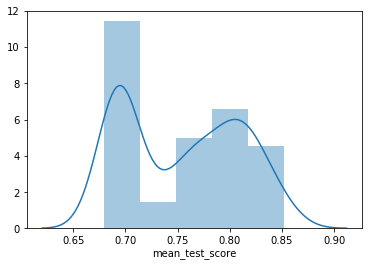

In [93]:
sns.distplot(results['mean_test_score'])
plt.show()

In [94]:
estimator.best_params_

{'clf__C': 1.0,
 'clf__kernel': 'linear',
 'reduce_dim': None,
 'select_features__drt': 0,
 'select_features__group': False,
 'select_features__npeaks': 0}

In [96]:
estimator.best_score_

0.85221674876847286

In [98]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,10936,10937,10938,10939,10940,10941,10942,10943,10944,10945
new_index,,,,,,,,,,,,,,,,,,,,,
20120829_133,2900.6,175.075,4618.51,4355.05,8037.76,465.758,12823.1,5232.53,497.595,913.738,...,86166.3,568.655,3942.04,26795.1,2523.34,7223.63,511.758,851.452,742.501,287.056
20120829_323,785.574,NaN,4192.91,3969.77,2817.08,211.268,4252.48,1988.08,472.857,749.671,...,13565.5,166.94,3778.07,3498.89,1072.77,915.935,554.849,612.891,2070.85,499.686
20120829_114,1898.09,275.44,3129.57,7930.24,7174.47,242.863,9143.71,4906.68,1115.17,793.025,...,60898.1,184.582,14359.1,19392.1,8318.18,4035.2,2857.59,1505.53,2549.88,782.967
20120829_340,941.002,NaN,3697.67,3386.37,2170.57,197.355,5336.28,1031.41,418.866,365.597,...,11040.4,340.757,3157.36,3141.48,984.862,425.045,328.233,624.179,2079.18,495.569
20120829_352,817.086,NaN,2681.52,3656.53,1860.69,242.263,5606.28,2479.57,536.069,591.585,...,34215.2,449.862,1363.75,9408.78,661.637,1273.46,271.674,278.621,469.027,165.468
20120829_329,1181.78,6.3812,4941.91,3662.67,2866.93,219.346,5234.35,1417.59,746.417,324.604,...,11330.8,218.151,3533.26,4142.64,1208.81,916.481,262.333,522.816,2321.73,690.152
20120829_358,869.314,NaN,2715.87,3457.52,2794.55,242.785,5097.31,1109.31,445.688,1087.5,...,1037.62,133.869,1778.2,464.594,595.217,124.698,183.788,404.872,294.747,134.731
20120829_179,3950.25,40.3708,2717.03,7063.71,8561.04,579.066,16309.8,6236.35,604.389,1352.77,...,18126.7,117.105,1271.19,5698.24,672.209,1062.86,209.278,309.962,336.182,140.175
20120829_335,827.518,NaN,4094.74,3326.76,1908.91,249.683,3218.61,977.896,493.226,655.884,...,7637.58,121.682,2516.62,2269.66,691.583,486.602,397.204,706.721,1635.48,421.7
